In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
train='Data/UNSW_NB15_training-set.csv'

train_data=pd.read_csv(train)

In [5]:
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
train_data.shape

(82332, 45)

In [7]:
# number of attack labels 
train_data['label'].value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [8]:
train_data = train_data[0:10000]

In [9]:
# distribution of attack classes
train_data.label.value_counts()

1    9757
0     243
Name: label, dtype: int64

In [10]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
train_data['proto']= label_encoder.fit_transform(train_data['proto'])
train_data['state']= label_encoder.fit_transform(train_data['state'])

train_data['proto'].unique()
train_data['state'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
id                   10000 non-null int64
dur                  10000 non-null float64
proto                10000 non-null int32
service              10000 non-null object
state                10000 non-null int32
spkts                10000 non-null int64
dpkts                10000 non-null int64
sbytes               10000 non-null int64
dbytes               10000 non-null int64
rate                 10000 non-null float64
sttl                 10000 non-null int64
dttl                 10000 non-null int64
sload                10000 non-null float64
dload                10000 non-null float64
sloss                10000 non-null int64
dloss                10000 non-null int64
sinpkt               10000 non-null float64
dinpkt               10000 non-null float64
sjit                 10000 non-null float64
djit                 10000 non-null float64
swin                 10000 non-null

In [12]:
del train_data['service']
del train_data['attack_cat']

In [13]:
del train_data['id']

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
dur                  10000 non-null float64
proto                10000 non-null int32
state                10000 non-null int32
spkts                10000 non-null int64
dpkts                10000 non-null int64
sbytes               10000 non-null int64
dbytes               10000 non-null int64
rate                 10000 non-null float64
sttl                 10000 non-null int64
dttl                 10000 non-null int64
sload                10000 non-null float64
dload                10000 non-null float64
sloss                10000 non-null int64
dloss                10000 non-null int64
sinpkt               10000 non-null float64
dinpkt               10000 non-null float64
sjit                 10000 non-null float64
djit                 10000 non-null float64
swin                 10000 non-null int64
stcpb                10000 non-null int64
dtcpb                10000 non-null 

In [15]:
X = train_data.drop(["label"],axis =1)
y = train_data["label"]

# Feature Selection

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
rfecv = RFECV(cv=2, estimator=LogisticRegression(),
      scoring='accuracy')

rfecv.fit(X,y)

RFECV(cv=2, estimator=LogisticRegression(), scoring='accuracy')

In [17]:
#to get number of the features
display('Number of features:', rfecv.n_features_)

#to get feature names
list(X.columns[rfecv.support_]) 

'Number of features:'

6

['spkts',
 'dloss',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_src_ltm',
 'ct_src_ltm']

In [18]:
df = train_data[['spkts',
     'dloss',
     'ct_srv_src',
     'ct_state_ttl',
     'ct_dst_src_ltm',
     'ct_src_ltm',
             'label']]
df.to_csv('unsw_processed.csv')

In [19]:
X_2 = train_data[['spkts',
     'dloss',
     'ct_srv_src',
     'ct_state_ttl',
     'ct_dst_src_ltm',
     'ct_src_ltm']]

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 6), (8000,), (2000, 6), (2000,))

In [21]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []
auc = []
geo = []
spec = []
sens = []


#function to call for storing the results
def storeResults(model, a,b,c,d,e,f,g,h):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))
    auc.append(round(e,3))
    geo.append(round(f,3))
    spec.append(round(g,3))
    sens.append(round(h,3))
    

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, det_curve
from imblearn.metrics import geometric_mean_score,specificity_score,sensitivity_score

# Original

# SVM

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.993 total time=   1.3s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.989 total time=   2.1s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.989 total time=   2.2s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.986 total time=   2.1s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.989 total time=   2.1s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.993 total time=   1.2s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.988 total time=   1.1s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.988 total time=   1.1s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.984 total time=   1.1s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.988 total time=   1.1s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.993 total time=   0.6s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

In [24]:
svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_pred, y_test,average='weighted')
svm_rec = recall_score(y_pred, y_test,average='weighted')
svm_f1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
svm_geo = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec = specificity_score(y_test, y_pred, average='weighted')
svm_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - SVM',svm_acc,svm_prec,svm_rec,svm_f1,svm_auroc,svm_geo,svm_spec,svm_sens)

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = forest.predict(X_test)

In [26]:
rf_acc = accuracy_score(y_pred, y_test)
rf_prec = precision_score(y_pred, y_test,average='weighted')
rf_rec = recall_score(y_pred, y_test,average='weighted')
rf_f1 = f1_score(y_pred, y_test,average='weighted')
rf_auroc = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
rf_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf_spec = specificity_score(y_test, y_pred, average='weighted')
rf_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - RF',rf_acc,rf_prec,rf_rec,rf_f1,rf_auroc,rf_geo,rf_spec,rf_sens)

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = tree.predict(X_test)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


In [28]:
dt_acc = accuracy_score(y_pred, y_test)
dt_prec = precision_score(y_pred, y_test,average='weighted')
dt_rec = recall_score(y_pred, y_test,average='weighted')
dt_f1 = f1_score(y_pred, y_test,average='weighted')
dt_auroc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt_spec = specificity_score(y_test, y_pred, average='weighted')
dt_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - DT',dt_acc,dt_prec,dt_rec,dt_f1,dt_auroc,dt_geo,dt_spec,dt_sens)

# Stacking CLassifier

In [29]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf_ = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf_.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf_.predict(X_test)

In [30]:
stac_acc = accuracy_score(y_pred, y_test)
stac_prec = precision_score(y_pred, y_test,average='weighted')
stac_rec = recall_score(y_pred, y_test,average='weighted')
stac_f1 = f1_score(y_pred, y_test,average='weighted')
stac_auroc = roc_auc_score(y_test, clf_.predict_proba(X_test)[:, 1])
stac_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac_spec = specificity_score(y_test, y_pred, average='weighted')
stac_sens = sensitivity_score(y_test, y_pred, average='weighted')

stac_acc
storeResults('Original - Stacking',stac_acc,stac_prec,stac_rec,stac_f1,stac_auroc,stac_geo,stac_spec,stac_sens)

# SVM - SMOTE

In [31]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=2)
X_res, y_res = sm.fit_resample(X_2, y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 42)

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(X_test)

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_test, svm1.predict_proba(X_test)[:, 1])
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.952 total time=   7.2s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.954 total time=   7.3s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.953 total time=   7.2s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.949 total time=   7.1s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.955 total time=   7.1s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.944 total time=   7.0s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.953 total time=   7.0s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.942 total time=   6.8s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.943 total time=   6.9s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.939 total time=   6.8s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.906 total time=   9.5s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(X_test)

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_test, forest1.predict_proba(X_test)[:, 1])
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(X_test)

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_test, tree1.predict_proba(X_test)[:, 1])
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

In [37]:
stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

stac1_acc
storeResults('SMOTE-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# CDAAE

In [38]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [39]:
n_inputs = X_2.shape[1]

print(y[:5])

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs * 2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [42]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [43]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [44]:
history = model.fit(X_train, X_train, epochs=20, batch_size=2, verbose=0, validation_data=(X_test,X_test))

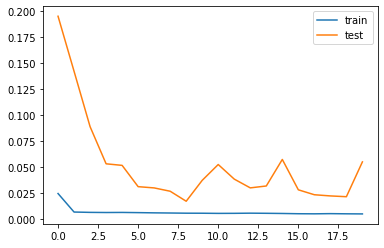

In [45]:
from matplotlib import pyplot

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [46]:
encoder = Model(inputs=visible, outputs=bottleneck)
#plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)

In [47]:
# save the encoder to file
encoder.save('encoder1.h5')

In [48]:
# load the model from file
from keras.models import load_model
encoder = load_model('encoder1.h5')

## We can then use the encoder to transform the raw input data (e.g. 100 columns) 
## into bottleneck vectors (e.g. 50 element vectors).
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

# SVM

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(X_test_encode)

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_test, svm1.predict_proba(X_test_encode)[:, 1])
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.990 total time=   0.4s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.987 total time=   0.3s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.987 total time=   0.3s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.987 total time=   0.3s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.986 total time=   0.3s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.990 total time=   0.2s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.987 total time=   0.2s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.988 total time=   0.2s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.987 total time=   0.2s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.986 total time=   0.2s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.982 total time=   0.2s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# RAndom FOrest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(X_test_encode)

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_test, forest1.predict_proba(X_test_encode)[:, 1])
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(X_test_encode)

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_test, tree1.predict_proba(X_test_encode)[:, 1])
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [52]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

stac1_acc
storeResults('CDAAE-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# CDAAE-KNN

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.33, random_state=1)

In [54]:
import matplotlib.pyplot as plt
n_train = np.array(X_train)
n_test = np.array(X_test)

6
(6700, 6)


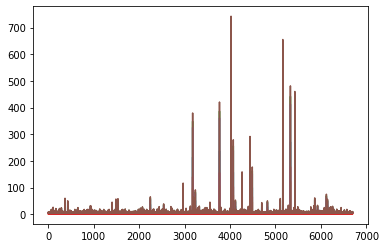

In [55]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

input_dim = n_train.shape[1]
feature_dim = [25, 20, 15, 10]
print(input_dim)
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(feature_dim[0], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[1], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[2], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[3], kernel_initializer="uniform")(encoded)

decoded = encoded
decoded = Dense(feature_dim[2], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[1], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[0], kernel_initializer="uniform")(decoded)
decoded = Dense(input_dim, kernel_initializer="uniform")(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(n_train, n_train,
                verbose=0,
                epochs=200,
                batch_size=2,
                shuffle=True,
                validation_data=(n_test, n_test))

predict_vals = autoencoder.predict(n_train)
print(predict_vals.shape)
plt.plot(predict_vals)
plt.show()

In [56]:
from keras.models import Sequential

featuremodel = Sequential()
featuremodel.add(Dense(feature_dim[0], input_shape=(input_dim,), weights=autoencoder.layers[1].get_weights()))
featuremodel.add(Dense(feature_dim[1], weights=autoencoder.layers[2].get_weights()))
featuremodel.add(Dense(feature_dim[2], weights=autoencoder.layers[3].get_weights()))
featuremodel.add(Dense(feature_dim[3], weights=autoencoder.layers[4].get_weights()))

featuremodel.compile(optimizer='adadelta', loss='mse')

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print("Accuracy: %s" % "{0:.3%}".format(metrics.accuracy_score(prediction, y_test)))

Accuracy: 98.697%


# SVM

In [57]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(featuremodel.predict(n_test))

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_test, svm1.predict_proba(featuremodel.predict(n_test))[:, 1])
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.976 total time=   0.3s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.975 total time=   0.3s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.975 total time=   0.3s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.975 total time=   0.3s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.975 total time=   0.3s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.976 total time=   0.2s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.975 total time=   0.2s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.975 total time=   0.2s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.975 total time=   0.2s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.975 total time=   0.2s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.976 total time=   0.2s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# Random FOrest

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(featuremodel.predict(n_test))

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_test, forest1.predict_proba(featuremodel.predict(n_test))[:, 1])
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(featuremodel.predict(n_test))

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_test, tree1.predict_proba(featuremodel.predict(n_test))[:, 1])
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [60]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

stac1_acc
storeResults('CDAAE-KNN-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# Comparison

In [61]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                       'AUC Score' : auc,
                       'Geometric Metric Score' : geo,
                       'Specificity' : spec,
                       'Sensitivity' : sens
                        
                      }) 

In [62]:
result

,ML Model,Accuracy,Precision,Recall,F1_score,AUC Score,Geometric Metric Score,Specificity,Sensitivity
0,Original - SVM,0.981,0.989,0.981,0.984,0.682,0.613,0.383,0.981
1,Original - RF,0.982,0.986,0.982,0.984,0.959,0.688,0.482,0.982
2,Original - DT,0.984,0.994,0.984,0.988,0.935,0.614,0.383,0.984
3,Original - Stacking,0.982,0.988,0.982,0.984,0.954,0.659,0.442,0.982
4,SMOTE - SVM,0.950,0.951,0.950,0.950,0.964,0.950,0.951,0.950
5,SMOTE - RF,0.951,0.952,0.951,0.951,0.989,0.951,0.952,0.951
6,SMOTE - DT,0.950,0.951,0.950,0.950,0.988,0.950,0.951,0.950
7,SMOTE-STACKING,0.951,0.952,0.951,0.951,0.989,0.952,0.952,0.951
8,CDAAE - SVM,0.986,0.994,0.986,0.989,0.838,0.662,0.444,0.986
9,CDAAE - RF,0.988,0.992,0.988,0.989,0.924,0.757,0.580,0.988


# Graph

In [63]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

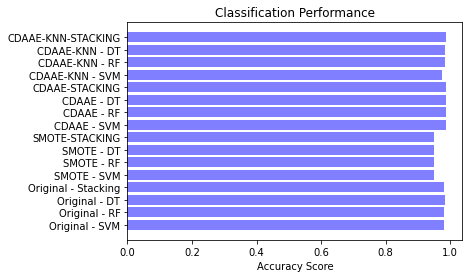

In [64]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

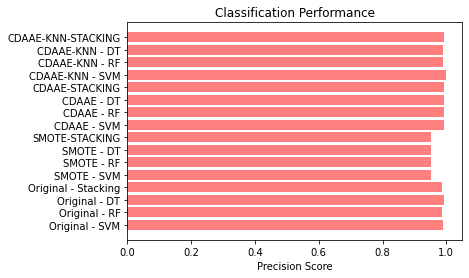

In [65]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

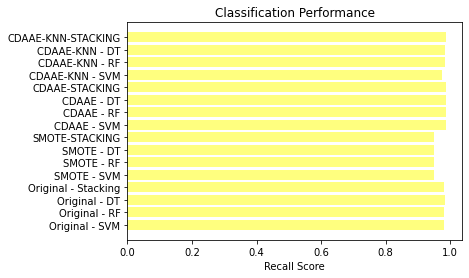

In [66]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1Score

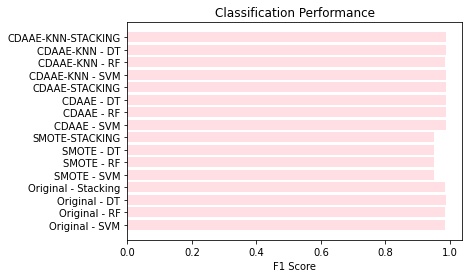

In [67]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# AUC Score

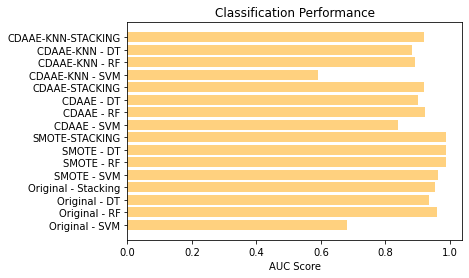

In [68]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, auc, align='center', alpha=0.5,color='orange')
plt2.yticks(y_pos, classifier)
plt2.xlabel('AUC Score')
plt2.title('Classification Performance')
plt2.show()

# Geometric SCore

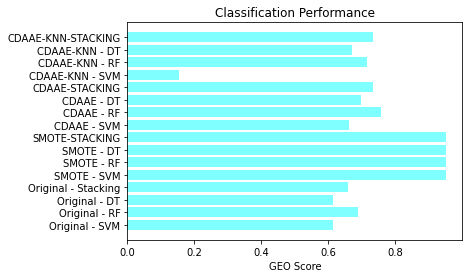

In [69]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, geo, align='center', alpha=0.5,color='cyan')
plt2.yticks(y_pos, classifier)
plt2.xlabel('GEO Score')
plt2.title('Classification Performance')
plt2.show()

# Specificity

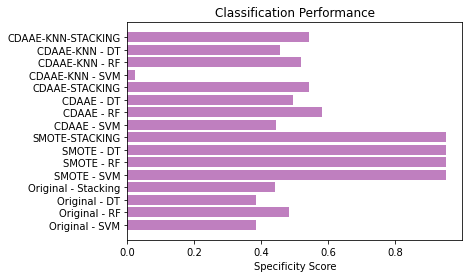

In [70]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, spec, align='center', alpha=0.5,color='purple')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Specificity Score')
plt2.title('Classification Performance')
plt2.show()

# Sensitivity

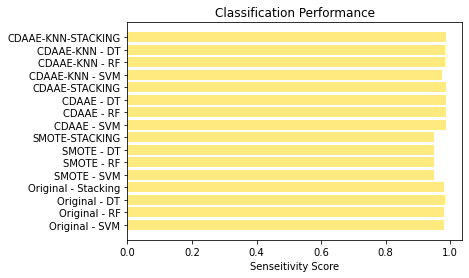

In [71]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, sens, align='center', alpha=0.5,color='gold')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Senseitivity Score')
plt2.title('Classification Performance')
plt2.show()

# Modelling

In [72]:
import joblib
filename = 'model_unsw.sav'
joblib.dump(clf_, filename)

['model_unsw.sav']